In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib.animation import FuncAnimation



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# For creating the football filed
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
%matplotlib inline

# Goal: predicting the tackle time based on tracking covariates

**What needs to be done:**

1. All plays need to be filtered for whether there exists a tackle event in them
2. For all such plays, the tracking info of the ball carrier and the tackler need to be extracted
3. For all tackle games, the first contact times as well as the tackle times need to be determined
    * for plays where there is no "first contact" event, an alternative way needs to be chosen to mark the first contact moment
4. Based on these two time points the tackle time can be calculated
5. Tracking data needs to be collapsed, such that there are is a single row for each play left, which can be used in the model

<h1> Read in the data </h1>

In [4]:
games = pd.read_csv("D:/R/NFL_Data/games.csv")
players = pd.read_csv("D:/R/NFL_Data/players.csv")
plays = pd.read_csv("D:/R/NFL_Data/plays.csv")
tackles = pd.read_csv("D:/R/NFL_Data/tackles.csv")

In [5]:
tracking_one = pd.read_csv("D:/R/NFL_Data/tracking_week_1.csv")
tracking_two = pd.read_csv("D:/R/NFL_Data/tracking_week_2.csv")
tracking_three = pd.read_csv("D:/R/NFL_Data/tracking_week_3.csv")
tracking_four = pd.read_csv("D:/R/NFL_Data/tracking_week_4.csv")
tracking_five = pd.read_csv("D:/R/NFL_Data/tracking_week_5.csv")
tracking_six = pd.read_csv("D:/R/NFL_Data/tracking_week_6.csv")
tracking_seven = pd.read_csv("D:/R/NFL_Data/tracking_week_7.csv")
tracking_eight = pd.read_csv("D:/R/NFL_Data/tracking_week_8.csv")
tracking_nine = pd.read_csv("D:/R/NFL_Data/tracking_week_9.csv")

In [6]:
# concatenate all tracking data sets to one big dataframe
tracking = pd.concat([tracking_one,tracking_two,tracking_three,tracking_four,tracking_five,tracking_six,tracking_seven,tracking_eight,tracking_nine])

<h1> Step 0: Concatenate gameId and playId to a joined gamePlayId column in all relevant dataframes</h1>

In [7]:
# play dataframe
game_play_id = plays["gameId"].astype(str) + plays["playId"].astype(str)
plays.insert(loc=0, column='gamePlayId', value=game_play_id)

# tackle dataframe
game_play_id = tackles["gameId"].astype(str) + tackles["playId"].astype(str)
tackles.insert(loc=0, column='gamePlayId', value=game_play_id)

# tracking dataframe
game_play_id = tracking["gameId"].astype(str) + tracking["playId"].astype(str)
tracking.insert(loc=0, column='gamePlayId', value=game_play_id)

<h1> Step 1: select only plays, that have a tackle event in them </h1>

In [8]:
# filter out plays that are not in the tackle table
tackle_plays = np.unique(tracking[tracking["event"] == "tackle"]["gamePlayId"])
tracking_data = tracking[tracking['gamePlayId'].isin(tackle_plays)]

<h1> Step 2: get tracking data for ballcarrier and tackler only </h1>

<h3> extract nflIds of tacklers for each play, add them to play data (ballcarrier info is allready present)

In [9]:
# get the nflIds of the tacklers and add them to the play data
tacklers = tackles[["gamePlayId","nflId"]]
tacklers.columns=["gamePlayId", "tacklerId"]
# add the tackler info to the play dataset
tracking_data = tracking_data.merge(tacklers, on="gamePlayId", how="left")

In [10]:
tracking_data

,gamePlayId,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,tacklerId
0,202209080056,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.370000,27.270000,1.62,1.15,0.16,231.74,147.90,NaN,43294.0
1,202209080056,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.470000,27.130000,1.67,0.61,0.17,230.98,148.53,pass_arrived,43294.0
2,202209080056,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.560000,27.010000,1.57,0.49,0.15,230.98,147.05,NaN,43294.0
3,202209080056,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.640000,26.900000,1.44,0.89,0.14,232.38,145.42,NaN,43294.0
4,202209080056,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.720000,26.800000,1.29,1.24,0.13,233.36,141.95,NaN,43294.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16009783,20221107003787,2022110700,3787,NaN,football,40,2022-11-07 23:06:49.200000,NaN,football,right,26.219999,19.680000,1.37,2.58,0.15,NaN,NaN,tackle,52578.0
16009784,20221107003787,2022110700,3787,NaN,football,41,2022-11-07 23:06:49.299999,NaN,football,right,26.320000,19.610001,1.07,2.74,0.12,NaN,NaN,NaN,52578.0
16009785,20221107003787,2022110700,3787,NaN,football,42,2022-11-07 23:06:49.400000,NaN,football,right,26.389999,19.559999,0.80,2.49,0.09,NaN,NaN,NaN,52578.0
16009786,20221107003787,2022110700,3787,NaN,football,43,2022-11-07 23:06:49.500000,NaN,football,right,26.450001,19.520000,0.57,2.38,0.07,NaN,NaN,NaN,52578.0


<h3> get only the tracking data for the ballcarriers and tacklers

In [11]:
# add the ids of the tackler and ballcarrier to the relevant tracking data
merged_df = pd.merge(tracking_data, plays[['gamePlayId', 'ballCarrierId']], on='gamePlayId', how='left')

# afterwards: filter out only those entries, where the player's id matches eather the ballcarrier or tackler id
tracking_data = merged_df[(merged_df['nflId'] == merged_df['ballCarrierId']) | (merged_df['nflId'] == merged_df['tacklerId'])].reset_index()

# add "isBallCarrier" column to the data, indicating whether the player is the ballcarrier or not
tracking_data['isBallCarrier'] = (tracking_data['nflId'] == tracking_data['ballCarrierId']).astype(int)
tracking_data = tracking_data.drop_duplicates()

**tracking_data now only consists of the tracking rows for ballcarrier and tackler of all relevant tackle plays**

<h3> pivot the data to a wide format </h3>

In [12]:
# introduce a play column that is either ballCarrier or tackler respectively, used to rename the column after the pivot
tracking_data['player'] = tracking_data.apply(lambda row: 'tackler' if row['isBallCarrier'] == 0 else 'ballcarrier', axis=1)

# pivot the dataframe, using the selected numerical features
features = ['x', 'y', 's', 'a', 'dis', 'dir', 'event', "nflId"]
pivot_tracking = tracking_data.pivot_table(index=['gamePlayId', 'frameId'], columns='player', values=features, aggfunc='first').reset_index()
# rename the columns
pivot_tracking.columns = [f'{col[0]}.{col[1]}' if col[1] != '' else f'{col[0]}' for col in pivot_tracking.columns]

print(pivot_tracking["x.tackler"].isna().sum())
# for some reason some tackler coordinates are NA. i will drop them for now
pivot_tracking = pivot_tracking[~pivot_tracking["x.tackler"].isna()]

pivot_tracking.drop(columns=["event.ballcarrier"], inplace=True)
pivot_tracking.rename(columns={"event.tackler" : "event"}, inplace=True)

176


In [13]:
safe = pivot_tracking

In [14]:
pivot_tracking

,gamePlayId,frameId,a.ballcarrier,a.tackler,dir.ballcarrier,dir.tackler,dis.ballcarrier,dis.tackler,event,nflId.ballcarrier,nflId.tackler,s.ballcarrier,s.tackler,x.ballcarrier,x.tackler,y.ballcarrier,y.tackler
0,2022090800101,1,0.00,0.55,255.74,108.97,0.00,0.01,None,47857.0,42816.0,0.00,0.06,79.61,64.67,29.56,40.76
1,2022090800101,2,0.00,0.56,258.97,7.85,0.00,0.01,None,47857.0,42816.0,0.00,0.08,79.60,64.67,29.56,40.77
2,2022090800101,3,0.00,0.68,259.87,356.70,0.00,0.02,None,47857.0,42816.0,0.00,0.20,79.60,64.66,29.56,40.79
3,2022090800101,4,0.00,0.59,259.74,0.46,0.00,0.03,None,47857.0,42816.0,0.00,0.30,79.60,64.66,29.56,40.81
4,2022090800101,5,0.00,0.43,263.81,0.20,0.00,0.04,None,47857.0,42816.0,0.00,0.40,79.60,64.66,29.56,40.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436728,2022110700950,55,0.26,0.58,301.73,3.99,0.02,0.00,tackle,43362.0,37097.0,0.09,0.09,71.53,71.91,31.90,31.26
436729,2022110700950,56,0.20,0.67,302.24,184.18,0.01,0.02,None,43362.0,37097.0,0.07,0.06,71.52,71.91,31.90,31.25
436730,2022110700950,57,0.15,0.78,322.17,205.73,0.06,0.02,None,43362.0,37097.0,0.05,0.19,71.55,71.89,31.96,31.23
436731,2022110700950,58,0.11,0.66,344.49,206.14,0.08,0.03,None,43362.0,37097.0,0.06,0.28,71.57,71.88,32.04,31.21


<h1> Step 3: determine first contact and tackle frame </h1>

<h3> first case: first_contact event is present

In [15]:
# determine the frame at which each play has its first_contact event, if present. 
first_contact_events = pivot_tracking[pivot_tracking["event"] == "first_contact"][["gamePlayId", "frameId"]].drop_duplicates(subset=["gamePlayId"])
first_contact_events.columns=["gamePlayId", "firstContactEventTime"]
first_contact_events.head()

,gamePlayId,firstContactEventTime
37,2022090800101,38
56,20220908001030,8
82,20220908001102,14
147,20220908001187,29
193,2022090800122,20


In [16]:
# add firstContactEventTime to pivot dataframe
pivot_tracking = pivot_tracking.merge(first_contact_events, on="gamePlayId", how="left")

<h3> Second case: in case first_contact event does not exists, determine the closest distance between the two players </h3>

**determine distance between ballcarrier and tackler for each time point**

In [17]:
pivot_tracking['distance'] = np.sqrt((pivot_tracking['x.ballcarrier'] - pivot_tracking['x.tackler'])**2 +
                                    (pivot_tracking['y.ballcarrier'] - pivot_tracking['y.tackler'])**2)

gamePlayIds_without_first_contact = set(list(tracking_data["gamePlayId"].unique())) - set(list(tracking_data[tracking_data["event"] == "first_contact"]["gamePlayId"].unique()))

no_fc_df = pivot_tracking[pivot_tracking["gamePlayId"].isin(gamePlayIds_without_first_contact)]
no_fc_df

,gamePlayId,frameId,a.ballcarrier,a.tackler,dir.ballcarrier,dir.tackler,dis.ballcarrier,dis.tackler,event,nflId.ballcarrier,nflId.tackler,s.ballcarrier,s.tackler,x.ballcarrier,x.tackler,y.ballcarrier,y.tackler,firstContactEventTime,distance
274,20220908001334,1,2.34,2.66,79.14,191.38,0.19,0.63,None,41290.0,46085.0,1.80,6.31,37.22,38.64,10.53,16.29,NaN,5.932453
275,20220908001334,2,2.31,2.46,73.68,193.45,0.17,0.62,pass_arrived,41290.0,46085.0,1.64,6.17,37.39,38.50,10.57,15.69,NaN,5.238941
276,20220908001334,3,2.78,2.33,55.97,195.15,0.15,0.61,None,41290.0,46085.0,1.52,6.02,37.51,38.35,10.65,15.10,NaN,4.528587
277,20220908001334,4,2.62,2.34,45.77,196.95,0.15,0.59,None,41290.0,46085.0,1.47,5.86,37.62,38.19,10.75,14.53,NaN,3.822735
278,20220908001334,5,2.75,2.36,31.00,198.39,0.19,0.58,None,41290.0,46085.0,1.71,5.68,37.72,38.01,10.91,13.98,NaN,3.083667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436272,2022110700646,40,3.95,2.84,173.76,185.51,0.21,0.18,tackle,43415.0,37097.0,1.97,1.69,81.36,81.10,14.75,16.16,NaN,1.433771
436273,2022110700646,41,4.27,2.59,177.80,186.19,0.18,0.15,None,43415.0,37097.0,1.51,1.42,81.38,81.09,14.57,16.01,NaN,1.468911
436274,2022110700646,42,3.87,2.51,182.53,180.96,0.13,0.11,None,43415.0,37097.0,1.11,1.05,81.37,81.10,14.44,15.90,NaN,1.484756
436275,2022110700646,43,3.49,2.32,191.53,171.67,0.09,0.07,None,43415.0,37097.0,0.74,0.72,81.37,81.12,14.34,15.83,NaN,1.510828


In [18]:
#determine min distance frames of those plays without first contact event
min_distance_frames = no_fc_df.loc[no_fc_df.groupby('gamePlayId')['distance'].idxmin(), ['gamePlayId', 'frameId']]
min_distance_frames

,gamePlayId,frameId
283,20220908001334,10
1355,20220908002527,10
1777,20220908002884,16
2245,20220908003362,31
2334,2022090800343,36
...,...,...
435252,20221107003299,9
435344,20221107003401,15
436070,2022110700518,7
436143,202211070056,11


In [19]:
# update the event column to "first_contact" for the minimal distance frames
for ind in min_distance_frames.index:
    playId = min_distance_frames['gamePlayId'][ind]
    frame = min_distance_frames['frameId'][ind]
    # this line causes overriding of tackle event if moment of least distance is tackle itself TODO: maybe find a fix for that?
    #pivot_tracking.loc[(pivot_tracking["gamePlayId"] == playId) & (pivot_tracking["frameId"] == frame), "event"] = "first_contact"
    pivot_tracking.loc[(pivot_tracking["gamePlayId"] == playId) ,"firstContactEventTime"] = frame

In [20]:
safe = pivot_tracking

<h3> Tackle event frames: determine the timeframe of the tackle event</h3>

In [21]:
tackle_events = tracking_data[tracking_data["event"] == "tackle"][["gamePlayId", "frameId"]].drop_duplicates()
tackle_events.columns=["gamePlayId", "tackle"]

first_contact_events = pivot_tracking[["gamePlayId", "firstContactEventTime"]].drop_duplicates()
first_contact_events.columns=["gamePlayId", "firstContact"]

# add tackle event times to event times df
event_times = tackle_events.merge(first_contact_events, on="gamePlayId", how = "left")
event_times

,gamePlayId,tackle,firstContact
0,202209080056,18,22.0
1,202209080080,26,20.0
2,2022090800101,45,38.0
3,2022090800122,29,20.0
4,2022090800146,52,38.0
...,...,...,...
10036,20221107003658,55,40.0
10037,20221107003686,72,31.0
10038,20221107003707,54,39.0
10039,20221107003740,38,31.0


<h1> Step 4: determine tackle time </h1>

In [22]:
event_times["tackleTime"] = event_times["tackle"] - event_times["firstContact"]

<h1> Step 4.5: determine distance of last frames </h1>

In [23]:
last_frames = pivot_tracking.sort_values(by=['gamePlayId', 'frameId'])


# Calculate the rolling sum of the last 5-15 distances for each ID
last_frames['dis.tackler.l5f'] = last_frames.groupby('gamePlayId')['dis.tackler'].rolling(window=5, min_periods=1).sum().reset_index(level=0, drop=True)
last_frames['dis.tackler.l7f'] = last_frames.groupby('gamePlayId')['dis.tackler'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True)
last_frames['dis.tackler.l10f'] = last_frames.groupby('gamePlayId')['dis.tackler'].rolling(window=10, min_periods=1).sum().reset_index(level=0, drop=True)
last_frames['dis.tackler.l15f'] = last_frames.groupby('gamePlayId')['dis.tackler'].rolling(window=15, min_periods=1).sum().reset_index(level=0, drop=True)

last_frames['dis.ballcarrier.l5f'] = last_frames.groupby('gamePlayId')['dis.ballcarrier'].rolling(window=5, min_periods=1).sum().reset_index(level=0, drop=True)
last_frames['dis.ballcarrier.l7f'] = last_frames.groupby('gamePlayId')['dis.ballcarrier'].rolling(window=7, min_periods=1).sum().reset_index(level=0, drop=True)
last_frames['dis.ballcarrier.l10f'] = last_frames.groupby('gamePlayId')['dis.ballcarrier'].rolling(window=10, min_periods=1).sum().reset_index(level=0, drop=True)
last_frames['dis.ballcarrier.l15f'] = last_frames.groupby('gamePlayId')['dis.ballcarrier'].rolling(window=15, min_periods=1).sum().reset_index(level=0, drop=True)

# Only keep the last value
last_frames = last_frames.groupby('gamePlayId').last().reset_index()

# Join back to pivot_tracking
pivot_tracking = pivot_tracking.merge(last_frames[["gamePlayId",'dis.tackler.l5f', 'dis.tackler.l7f', 'dis.tackler.l10f', 
                                                   'dis.tackler.l15f','dis.ballcarrier.l5f', 'dis.ballcarrier.l7f', 
                                                   'dis.ballcarrier.l10f', 'dis.ballcarrier.l15f']], on='gamePlayId', how='left')

In [24]:
safe = pivot_tracking

In [25]:
pivot_tracking

,gamePlayId,frameId,a.ballcarrier,a.tackler,dir.ballcarrier,dir.tackler,dis.ballcarrier,dis.tackler,event,nflId.ballcarrier,...,firstContactEventTime,distance,dis.tackler.l5f,dis.tackler.l7f,dis.tackler.l10f,dis.tackler.l15f,dis.ballcarrier.l5f,dis.ballcarrier.l7f,dis.ballcarrier.l10f,dis.ballcarrier.l15f
0,2022090800101,1,0.00,0.55,255.74,108.97,0.00,0.01,None,47857.0,...,38.0,18.672000,0.55,1.12,2.34,4.46,2.08,3.13,4.93,8.38
1,2022090800101,2,0.00,0.56,258.97,7.85,0.00,0.01,None,47857.0,...,38.0,18.670003,0.55,1.12,2.34,4.46,2.08,3.13,4.93,8.38
2,2022090800101,3,0.00,0.68,259.87,356.70,0.00,0.02,None,47857.0,...,38.0,18.690011,0.55,1.12,2.34,4.46,2.08,3.13,4.93,8.38
3,2022090800101,4,0.00,0.59,259.74,0.46,0.00,0.03,None,47857.0,...,38.0,18.702035,0.55,1.12,2.34,4.46,2.08,3.13,4.93,8.38
4,2022090800101,5,0.00,0.43,263.81,0.20,0.00,0.04,None,47857.0,...,38.0,18.726123,0.55,1.12,2.34,4.46,2.08,3.13,4.93,8.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436552,2022110700950,55,0.26,0.58,301.73,3.99,0.02,0.00,tackle,43362.0,...,29.0,0.744312,0.10,0.15,0.27,0.47,0.25,0.27,0.38,0.65
436553,2022110700950,56,0.20,0.67,302.24,184.18,0.01,0.02,None,43362.0,...,29.0,0.758024,0.10,0.15,0.27,0.47,0.25,0.27,0.38,0.65
436554,2022110700950,57,0.15,0.78,322.17,205.73,0.06,0.02,None,43362.0,...,29.0,0.805295,0.10,0.15,0.27,0.47,0.25,0.27,0.38,0.65
436555,2022110700950,58,0.11,0.66,344.49,206.14,0.08,0.03,None,43362.0,...,29.0,0.886002,0.10,0.15,0.27,0.47,0.25,0.27,0.38,0.65


# Step 5: collapse the columns to a single value for each play

**Custom features**

**mean difference between direction and orientation angle**

In [26]:
pivot_tracking['orientation_movement_diff_ballcarrier'] = abs(pivot_tracking['dis.ballcarrier'] - pivot_tracking['a.ballcarrier'])

pivot_tracking['orientation_movement_diff_tackler'] = abs(pivot_tracking['dis.tackler'] - pivot_tracking['a.tackler'])

result = pivot_tracking.groupby('gamePlayId').agg({'orientation_movement_diff_ballcarrier': 'mean', 'orientation_movement_diff_tackler': 'mean'}).reset_index()
result

,gamePlayId,orientation_movement_diff_ballcarrier,orientation_movement_diff_tackler
0,2022090800101,2.569592,2.764286
1,20220908001030,3.089000,3.837500
2,20220908001102,1.943400,1.793200
3,20220908001187,2.010000,1.943273
4,2022090800122,1.754545,2.481818
...,...,...,...
10030,2022110700670,1.659143,1.909429
10031,202211070080,1.961455,1.237636
10032,2022110700839,2.034444,3.152444
10033,2022110700929,2.012745,2.350980


**mean absolute difference between direction angles of ballcarrier and tackler**

In [27]:
pivot_tracking['abs_diff_direction'] = abs(pivot_tracking['dis.ballcarrier'] - pivot_tracking['dis.tackler'])

result_abs_diff_direction = pivot_tracking.groupby('gamePlayId').agg({'abs_diff_direction': 'mean'}).reset_index()
result_abs_diff_direction

,gamePlayId,abs_diff_direction
0,2022090800101,0.212041
1,20220908001030,0.145000
2,20220908001102,0.075200
3,20220908001187,0.055636
4,2022090800122,0.085152
...,...,...
10030,2022110700670,0.293286
10031,202211070080,0.211273
10032,2022110700839,0.244889
10033,2022110700929,0.122549


In [28]:
# merge and store for later
temp_covariates = result.merge(result_abs_diff_direction, on="gamePlayId", how="left")

**mean difference between direction at time of tackle**

In [29]:
pivot_tracking['abs_diff_direction'] = abs(pivot_tracking['dis.ballcarrier'] - pivot_tracking['dis.tackler'])

tackle_events = pivot_tracking[pivot_tracking['event'] == 'tackle']
#first_contact_events = pivot_tracking[pivot_tracking['event'] == 'first_contact']

# Group by gamePlayId and calculate the mean for each group
result_tackle = tackle_events.groupby('gamePlayId').agg({'abs_diff_direction': 'mean'}).reset_index()
result_tackle.columns = ["gamePlayId", "difference_direction_tackle"]
#result_first_contact = first_contact_events.groupby('gamePlayId').agg({'abs_diff_direction': 'mean'}).reset_index()
#result_first_contact.columns = ["gamePlayId", "difference_direction_first_contact"]

**temp_covariates = covariates that are not summary statistics and are already one value per play**

In [30]:
temp_covariates = temp_covariates.merge(result_tackle, on="gamePlayId", how="left")


In [31]:
pivot_tracking['abs_diff_speed'] = abs(pivot_tracking['s.ballcarrier'] - pivot_tracking['s.tackler'])

tackle_events = pivot_tracking[pivot_tracking['event'] == 'tackle']
#first_contact_events = pivot_tracking[pivot_tracking['event'] == 'first_contact']

# Group by gamePlayId and calculate the mean for each group
result_tackle_speed = tackle_events.groupby('gamePlayId').agg({'abs_diff_speed': 'mean'}).reset_index()
result_tackle_speed.columns = ["gamePlayId", "difference_speed_tackle"]
#result_first_contact_speed = first_contact_events.groupby('gamePlayId').agg({'abs_diff_speed': 'mean'}).reset_index()
#result_first_contact_speed.columns = ["gamePlayId", "difference_speed_first_contact"]

In [32]:
temp_covariates = temp_covariates.merge(result_tackle_speed, on="gamePlayId", how="left")

In [33]:
pivot_tracking.to_csv('tracking_pivoted.csv',index=False)

# Turning angle average over last 5 frames prior to first contact

In [34]:
# determine turning angle for tackler and ballcarrier
pivot_tracking.sort_values(by=['gamePlayId', 'frameId'], inplace=True)

columns_to_diff = ['dir.ballcarrier', 'dir.tackler']  # Add more if needed

# Calculate absolute differences for each column
for column in columns_to_diff:
    diff_column = f'{column}_diff'
    pivot_tracking[diff_column] = pivot_tracking.groupby('gamePlayId')[column].diff().abs().fillna(0)

pivot_tracking.rename(columns= {"dir.ballcarrier_diff": "turning_angle_ballcarrier", "dir.tackler_diff" : "turning_angle_tackler"}, inplace=True)

In [35]:
first_contact_frames = pivot_tracking[(pivot_tracking["frameId"] == pivot_tracking["firstContactEventTime"])][["gamePlayId", "firstContactEventTime"]]
first_contact_frames

,gamePlayId,firstContactEventTime
37,2022090800101,38.0
56,20220908001030,8.0
82,20220908001102,14.0
147,20220908001187,29.0
193,2022090800122,20.0
...,...,...
436330,2022110700670,54.0
436376,202211070080,30.0
436426,2022110700839,25.0
436475,2022110700929,29.0


In [36]:
indices = list(first_contact_frames.index)
frames = list(first_contact_frames["firstContactEventTime"].astype("int"))

# function that caluclates the average of turning angles for n frames before the first contact frame
def calculate_average(index, fc_frame, n):
    
    steps_back = min(n, fc_frame)
    start_index = max(0, index - steps_back)  # Adjust the number of rows based on the integer number
    selected_rows = pivot_tracking.iloc[start_index:index]
    ballcarrier_average = round(selected_rows['turning_angle_ballcarrier'].mean(),3)
    tackler_average = round(selected_rows['turning_angle_tackler'].mean(),3)

    return (ballcarrier_average, tackler_average)


# Use the function for each index and corresponding number in the lists
balllcarrier_averages_5f, tackler_averages_5f = zip(*[calculate_average(index, number, 5) for index, number in zip(indices, frames)])
balllcarrier_averages_7f, tackler_averages_7f = zip(*[calculate_average(index, number, 7) for index, number in zip(indices, frames)])
balllcarrier_averages_10f, tackler_averages_10f = zip(*[calculate_average(index, number, 10) for index, number in zip(indices, frames)])


temp_covariates["turning_angle_avg.ballcarrier.l5f"] = balllcarrier_averages_5f
temp_covariates["turning_angle_avg.ballcarrier.l7f"] = balllcarrier_averages_7f
temp_covariates["turning_angle_avg.ballcarrier.l10f"] = balllcarrier_averages_10f
temp_covariates["turning_angle_avg.tackler.l5f"] = tackler_averages_5f
temp_covariates["turning_angle_avg.tackler.l7f"] = tackler_averages_7f
temp_covariates["turning_angle_avg.tackler.l10f"] = tackler_averages_10f


## Add some more covariates 

In [37]:
#change nflId to int
pivot_tracking['nflId.ballcarrier'] = pivot_tracking['nflId.ballcarrier'].astype(int)
pivot_tracking['nflId.tackler'] = pivot_tracking['nflId.tackler'].astype(int)

In [38]:
# add weight and height for ballcarrier

list_of_columns = ["nflId.tackler","nflId.ballcarrier","gamePlayId","height", "weight", "position"]

tracking_tmp = pd.merge(pivot_tracking, players, left_on='nflId.ballcarrier',right_on="nflId", how='left')[list_of_columns]
tracking_tmp = tracking_tmp.rename(columns={
    'height': 'ballcarrier.height',
    'weight': 'ballcarrier.weight',
    'position': 'ballcarrier.position'
})

# add weight and height for tackler

list_of_columns = list(tracking_tmp.columns)
list_of_columns.extend(["height", "weight", "position"])
tracking_tmp = pd.merge(tracking_tmp, players, left_on='nflId.tackler',right_on="nflId", how='left')[list_of_columns]
tracking_tmp = tracking_tmp.rename(columns={
    'height': 'tackler.height',
    'weight': 'tackler.weight',
    'position': 'tackler.position'
})

# add more covariates form plays: playDescription, quarter, down, 
#                                 yardsToGo, yardlineNumber, passLength, 
#                                 offenseFormation, defendersInTheBox  

list_of_columns = list(tracking_tmp.columns)
list_of_columns.extend([ "quarter", "down", 
                        "yardsToGo", "yardlineNumber", "passLength", 
                        "offenseFormation", "defendersInTheBox"])

tracking_tmp = pd.merge(tracking_tmp, plays, on="gamePlayId", how='left')[list_of_columns] 

tracking_tmp

,nflId.tackler,nflId.ballcarrier,gamePlayId,ballcarrier.height,ballcarrier.weight,ballcarrier.position,tackler.height,tackler.weight,tackler.position,quarter,down,yardsToGo,yardlineNumber,passLength,offenseFormation,defendersInTheBox
0,42816,47857,2022090800101,5-7,203,RB,5-11,184,CB,1,1,10,38,NaN,I_FORM,6.0
1,42816,47857,2022090800101,5-7,203,RB,5-11,184,CB,1,1,10,38,NaN,I_FORM,6.0
2,42816,47857,2022090800101,5-7,203,RB,5-11,184,CB,1,1,10,38,NaN,I_FORM,6.0
3,42816,47857,2022090800101,5-7,203,RB,5-11,184,CB,1,1,10,38,NaN,I_FORM,6.0
4,42816,47857,2022090800101,5-7,203,RB,5-11,184,CB,1,1,10,38,NaN,I_FORM,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436552,37097,43362,2022110700950,6-1,211,RB,6-4,287,DE,2,2,6,37,NaN,SHOTGUN,6.0
436553,37097,43362,2022110700950,6-1,211,RB,6-4,287,DE,2,2,6,37,NaN,SHOTGUN,6.0
436554,37097,43362,2022110700950,6-1,211,RB,6-4,287,DE,2,2,6,37,NaN,SHOTGUN,6.0
436555,37097,43362,2022110700950,6-1,211,RB,6-4,287,DE,2,2,6,37,NaN,SHOTGUN,6.0


gamePlayId                   0
ballcarrier.height           0
ballcarrier.weight           0
ballcarrier.position         0
tackler.height               0
tackler.weight               0
tackler.position             0
quarter                      0
down                         0
yardsToGo                    0
yardlineNumber               0
passLength              317019
offenseFormation            72
defendersInTheBox           72
dtype: int64


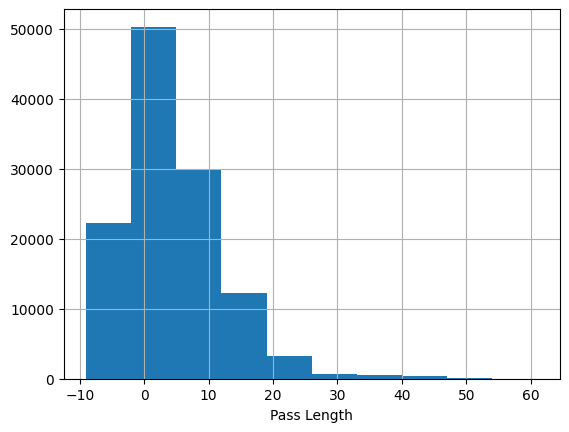

1.0
11.0


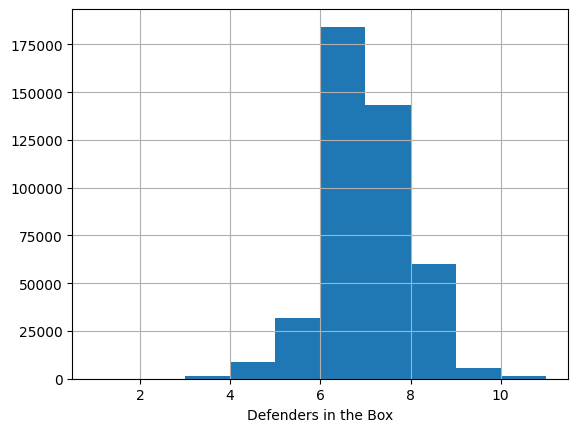

offenseFormation
SHOTGUN       197570
SINGLEBACK    146911
I_FORM         40210
PISTOL         24297
EMPTY          19794
JUMBO           3976
WILDCAT         3727
Name: count, dtype: int64
['I_FORM' 'SHOTGUN' 'SINGLEBACK' 'PISTOL' 'EMPTY' 'JUMBO' 'WILDCAT' nan]


In [80]:
#ask what to do with the NaN values in pass lenght
nan_counts = tracking_tmp.isna().sum()
print(nan_counts)

#convert hight in cm 

conversions = [30.48, 2.54]
tracking_tmp['ballcarrier.height'] = tracking_tmp['ballcarrier.height'].str.split('-').apply(pd.Series).astype(int).dot(conversions)
tracking_tmp['tackler.height'] = tracking_tmp['tackler.height'].str.split('-').apply(pd.Series).astype(int).dot(conversions)

#look into pass Lenght

tracking_tmp['passLength'].hist(bins=10)
plt.xlabel('Pass Length')
plt.show()

#only in about 25% of the data pass Length occurs 
#create a flag for that reason 

tracking_tmp['containsPassLength'] = tracking_tmp['passLength'].notna()

#Look at defendersInTheBox
tracking_tmp['defendersInTheBox'].hist(bins=10)

plt.xlabel('Defenders in the Box')

min_def = tracking_tmp["defendersInTheBox"].min()
max_def = tracking_tmp["defendersInTheBox"].max()

print(min_def)
print(max_def)

plt.show()

#fill NaN of defendersInTheBox with 0
tracking_tmp["defendersInTheBox"] = tracking_tmp["defendersInTheBox"].fillna(0)
tracking_tmp["defendersInTheBox"] = tracking_tmp["defendersInTheBox"].astype(int)
tracking_tmp

#Look at diffrent Formations
value_counts_offence = tracking_tmp["offenseFormation"].value_counts()
unique_offence = tracking_tmp["offenseFormation"].unique()

print(value_counts_offence)
print(unique_offence)
plt.show()

#fill NaN of offenseFormation with NoFormation
tracking_tmp["offenseFormation"] = tracking_tmp["offenseFormation"].fillna("0")
tracking_tmp = pd.get_dummies(tracking_tmp, columns = ['offenseFormation']) 


In [39]:
#prepare for later merge

tracking_tmp = tracking_tmp.drop("nflId.tackler", axis=1)
tracking_tmp = tracking_tmp.drop("nflId.ballcarrier", axis=1)



# colapsing columns to single values

In [40]:
# can and should be changed, probably way to many
aggregations = {
    'x.ballcarrier': ["mean"],
    'y.ballcarrier': [ "mean"],  
    'x.tackler': ["mean"], 
    'y.tackler': ["mean"],
    'dir.ballcarrier' : ["mean"],
    'dir.tackler' : [ "mean"],
    'dis.ballcarrier' : ["min", "max", "sum"],
    'dis.tackler' : ["min", "max", "sum"],
    #distances added
    's.ballcarrier' : ["min", "max", "mean"],
    's.tackler' : ["min", "max", "mean"], 
    'dis.tackler.l5f' : ["mean"], 
    'dis.tackler.l7f' : ["mean"], 
    'dis.tackler.l10f' : ["mean"], 
    'dis.tackler.l15f' : ["mean"], 
    'dis.ballcarrier.l5f' : ["mean"], 
    'dis.ballcarrier.l7f' : ["mean"], 
    'dis.ballcarrier.l10f' : ["mean"], 
    'dis.ballcarrier.l15f' : ["mean"],
    
}

# Group by playId and apply the aggregations
tracking_collapsed = pivot_tracking.groupby('gamePlayId').agg(aggregations).reset_index()

In [41]:
tracking_collapsed

gamePlayId x.ballcarrier y.ballcarrier  x.tackler  y.tackler  \
                               mean          mean       mean       mean   
0       2022090800101     75.253061     35.050204  66.814898  41.712245   
1      20220908001030     59.708500     37.546500  60.197000  37.428000   
2      20220908001102     85.280600     44.095000  86.938200  42.940600   
3      20220908001187     71.772000     33.520364  68.878182  31.508909   
4       2022090800122     64.413636     43.202121  61.442727  42.175152   
...               ...           ...           ...        ...        ...   
10030   2022110700670     80.033714     34.666429  84.899429  45.080286   
10031    202211070080     73.207818     34.290000  69.870182  38.778364   
10032   2022110700839     90.956889      9.824000  87.499333   5.848222   
10033   2022110700929     78.616275     30.907647  74.139216  31.151569   
10034   2022110700950     74.744915     30.310847  72.433559  32.447458   

      dir.ballcarrier dir.tackler dis.ballcarrier               ... s.tackler  \
                 mean        mean             min   max    sum  ...       max   
0          302.974286  147.468571            0.00  0.73  20.72  ...      4.55   
1          250.670000  273.294500            0.06  0.40   3.33  ...      3.98   
2          199.022400  289.684600            0.02  0.48  10.40  ...      4.82   
3          310.096727  235.846545            0.00  0.51  15.81  ...      4.99   
4          317.986061  171.866667            0.22  0.62  16.18  ...      7.00   
...               ...         ...             ...   ...    ...  ...       ...   
10030       43.853000  199.463286            0.01  0.84  30.95  ...      4.88   
10031      182.122182  136.870545            0.00  0.56  19.14  ...      5.66   
10032      197.506667  131.725778            0.14  0.66  22.77  ...      5.60   
10033      246.565686  124.263137            0.00  0.57  12.52  ...      4.17   
10034      270.382881  161.374746            0.00  0.52   9.11  ...      1.76   

                dis.tackler.l5f dis.tackler.l7f dis.tackler.l10f  \
           mean            mean            mean             mean   
0      2.230000            0.55            1.12             2.34   
1      2.940500            0.99            1.48             2.35   
2      1.918400            0.25            0.47             0.86   
3      3.260182            2.33            3.36             4.51   
4      5.228788            1.32            1.99             3.17   
...         ...             ...             ...              ...   
10030  1.925857            0.82            1.41             2.61   
10031  2.113455            2.33            3.44             5.13   
10032  3.261333            1.42            2.23             3.66   
10033  1.817255            0.51            0.76             1.48   
10034  0.877288            0.10            0.15             0.27   

      dis.tackler.l15f dis.ballcarrier.l5f dis.ballcarrier.l7f  \
                  mean                mean                mean   
0                 4.46                2.08                3.13   
1                 4.24                0.64                0.98   
2                 1.42                0.88                1.37   
3                 6.18                1.20                1.93   
4                 6.14                1.45                2.36   
...                ...                 ...                 ...   
10030             4.97                1.34                2.08   
10031             7.65                1.15                1.98   
10032             6.39                0.89                1.45   
10033             2.78                0.31                0.56   
10034             0.47                0.25                0.27   

      dis.ballcarrier.l10f dis.ballcarrier.l15f  
                      mean                 mean  
0                     4.93                 8.38  
1                     1.42                 1.88  
2                     2.12           

In [42]:
# drop the level and rename the columns
tracking_collapsed.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in tracking_collapsed.columns]
tracking_collapsed

,gamePlayId,x.ballcarrier_mean,y.ballcarrier_mean,x.tackler_mean,y.tackler_mean,dir.ballcarrier_mean,dir.tackler_mean,dis.ballcarrier_min,dis.ballcarrier_max,dis.ballcarrier_sum,...,s.tackler_max,s.tackler_mean,dis.tackler.l5f_mean,dis.tackler.l7f_mean,dis.tackler.l10f_mean,dis.tackler.l15f_mean,dis.ballcarrier.l5f_mean,dis.ballcarrier.l7f_mean,dis.ballcarrier.l10f_mean,dis.ballcarrier.l15f_mean
0,2022090800101,75.253061,35.050204,66.814898,41.712245,302.974286,147.468571,0.00,0.73,20.72,...,4.55,2.230000,0.55,1.12,2.34,4.46,2.08,3.13,4.93,8.38
1,20220908001030,59.708500,37.546500,60.197000,37.428000,250.670000,273.294500,0.06,0.40,3.33,...,3.98,2.940500,0.99,1.48,2.35,4.24,0.64,0.98,1.42,1.88
2,20220908001102,85.280600,44.095000,86.938200,42.940600,199.022400,289.684600,0.02,0.48,10.40,...,4.82,1.918400,0.25,0.47,0.86,1.42,0.88,1.37,2.12,2.93
3,20220908001187,71.772000,33.520364,68.878182,31.508909,310.096727,235.846545,0.00,0.51,15.81,...,4.99,3.260182,2.33,3.36,4.51,6.18,1.20,1.93,2.98,4.43
4,2022090800122,64.413636,43.202121,61.442727,42.175152,317.986061,171.866667,0.22,0.62,16.18,...,7.00,5.228788,1.32,1.99,3.17,6.14,1.45,2.36,3.89,6.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10030,2022110700670,80.033714,34.666429,84.899429,45.080286,43.853000,199.463286,0.01,0.84,30.95,...,4.88,1.925857,0.82,1.41,2.61,4.97,1.34,2.08,3.53,6.52
10031,202211070080,73.207818,34.290000,69.870182,38.778364,182.122182,136.870545,0.00,0.56,19.14,...,5.66,2.113455,2.33,3.44,5.13,7.65,1.15,1.98,3.43,6.18
10032,2022110700839,90.956889,9.824000,87.499333,5.848222,197.506667,131.725778,0.14,0.66,22.77,...,5.60,3.261333,1.42,2.23,3.66,6.39,0.89,1.45,2.55,4.92
10033,2022110700929,78.616275,30.907647,74.139216,31.151569,246.565686,124.263137,0.00,0.57,12.52,...,4.17,1.817255,0.51,0.76,1.48,2.78,0.31,0.56,1.11,2.54


**add the temp covariates from above**

In [43]:
tracking_collapsed = tracking_collapsed.merge(temp_covariates, on="gamePlayId", how="left")

#add covariates
tracking_collapsed = tracking_collapsed.merge(tracking_tmp, on="gamePlayId", how="left")

#exlude passlenght 
tracking_collapsed = tracking_collapsed.drop(columns=["passLength"])

In [44]:
tracking_collapsed[tracking_collapsed.isna().any(axis=1)]

,gamePlayId,x.ballcarrier_mean,y.ballcarrier_mean,x.tackler_mean,y.tackler_mean,dir.ballcarrier_mean,dir.tackler_mean,dis.ballcarrier_min,dis.ballcarrier_max,dis.ballcarrier_sum,...,ballcarrier.position,tackler.height,tackler.weight,tackler.position,quarter,down,yardsToGo,yardlineNumber,offenseFormation,defendersInTheBox
116711,2022092503459,80.100000,1.085385,79.524615,1.519231,151.090000,151.496923,0.19,0.49,5.38,...,WR,6-1,205,CB,1,3,10,22,NaN,NaN
116712,2022092503459,80.100000,1.085385,79.524615,1.519231,151.090000,151.496923,0.19,0.49,5.38,...,WR,6-1,205,CB,1,3,10,22,NaN,NaN
116713,2022092503459,80.100000,1.085385,79.524615,1.519231,151.090000,151.496923,0.19,0.49,5.38,...,WR,6-1,205,CB,1,3,10,22,NaN,NaN
116714,2022092503459,80.100000,1.085385,79.524615,1.519231,151.090000,151.496923,0.19,0.49,5.38,...,WR,6-1,205,CB,1,3,10,22,NaN,NaN
116715,2022092503459,80.100000,1.085385,79.524615,1.519231,151.090000,151.496923,0.19,0.49,5.38,...,WR,6-1,205,CB,1,3,10,22,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342263,20221023113663,87.916296,45.742963,89.994815,43.296296,37.747037,15.775556,0.64,0.96,23.55,...,QB,6-5,266,OLB,4,3,6,20,NaN,NaN
342264,20221023113663,87.916296,45.742963,89.994815,43.296296,37.747037,15.775556,0.64,0.96,23.55,...,QB,6-5,266,OLB,4,3,6,20,NaN,NaN
342265,20221023113663,87.916296,45.742963,89.994815,43.296296,37.747037,15.775556,0.64,0.96,23.55,...,QB,6-5,266,OLB,4,3,6,20,NaN,NaN
342266,20221023113663,87.916296,45.742963,89.994815,43.296296,37.747037,15.775556,0.64,0.96,23.55,...,QB,6-5,266,OLB,4,3,6,20,NaN,NaN


**finally, add the response to each row**

In [60]:
tracking_collapsed = tracking_collapsed.merge(event_times[["gamePlayId","tackleTime"]], on="gamePlayId", how="left")
tracking_collapsed

AttributeError: 'NoneType' object has no attribute 'merge'

In [233]:
tracking_collapsed = pd.read_csv("D:/R/NFL_Data/tracking_collapsed.csv")

In [231]:
tracking_collapsed

,gamePlayId,x.ballcarrier_mean,y.ballcarrier_mean,x.tackler_mean,y.tackler_mean,dir.ballcarrier_mean,dir.tackler_mean,dis.ballcarrier_min,dis.ballcarrier_max,dis.ballcarrier_sum,...,abs_diff_direction,difference_direction_tackle,difference_speed_tackle,turning_angle_avg.ballcarrier.l5f,turning_angle_avg.ballcarrier.l7f,turning_angle_avg.ballcarrier.l10f,turning_angle_avg.tackler.l5f,turning_angle_avg.tackler.l7f,turning_angle_avg.tackler.l10f,tackleTime
0,2022090800101,75.253061,35.050204,66.814898,41.712245,302.974286,147.468571,0.00,0.73,20.72,...,0.212041,0.29,2.94,5.006,4.291,3.700,10.818,11.929,10.988,7.0
1,20220908001030,59.708500,37.546500,60.197000,37.428000,250.670000,273.294500,0.06,0.40,3.33,...,0.145000,0.04,0.74,12.838,9.631,8.604,8.050,7.946,11.897,8.0
2,20220908001102,85.280600,44.095000,86.938200,42.940600,199.022400,289.684600,0.02,0.48,10.40,...,0.075200,0.16,1.60,8.588,8.944,8.152,1.440,2.564,3.882,32.0
3,20220908001187,71.772000,33.520364,68.878182,31.508909,310.096727,235.846545,0.00,0.51,15.81,...,0.055636,0.21,1.96,3.416,3.857,3.956,3.150,53.710,38.580,22.0
4,2022090800122,64.413636,43.202121,61.442727,42.175152,317.986061,171.866667,0.22,0.62,16.18,...,0.085152,0.06,0.80,3.490,2.976,2.271,73.288,53.120,38.049,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10030,2022110700670,80.033714,34.666429,84.899429,45.080286,43.853000,199.463286,0.01,0.84,30.95,...,0.293286,0.08,0.73,1.472,1.363,1.098,1.578,1.206,1.587,12.0
10031,202211070080,73.207818,34.290000,69.870182,38.778364,182.122182,136.870545,0.00,0.56,19.14,...,0.211273,0.23,1.77,2.546,1.903,1.713,15.232,13.891,11.392,21.0
10032,2022110700839,90.956889,9.824000,87.499333,5.848222,197.506667,131.725778,0.14,0.66,22.77,...,0.244889,0.13,1.34,3.054,2.229,2.320,12.066,11.927,9.654,16.0
10033,2022110700929,78.616275,30.907647,74.139216,31.151569,246.565686,124.263137,0.00,0.57,12.52,...,0.122549,0.05,0.42,0.774,0.767,0.726,62.160,44.617,31.443,18.0


In [101]:
tracking_collapsed.drop(columns=['tackleTime_x'], inplace=True)

In [102]:
tracking_collapsed.rename(columns={'tackleTime_y': 'tackleTime'}, inplace=True)

In [232]:
tracking_collapsed.columns

Index(['gamePlayId', 'x.ballcarrier_mean', 'y.ballcarrier_mean',
       'x.tackler_mean', 'y.tackler_mean', 'dir.ballcarrier_mean',
       'dir.tackler_mean', 'dis.ballcarrier_min', 'dis.ballcarrier_max',
       'dis.ballcarrier_sum', 'dis.tackler_min', 'dis.tackler_max',
       'dis.tackler_sum', 's.ballcarrier_min', 's.ballcarrier_max',
       's.ballcarrier_mean', 's.tackler_min', 's.tackler_max',
       's.tackler_mean', 'dis.tackler.l5f_mean', 'dis.tackler.l7f_mean',
       'dis.tackler.l10f_mean', 'dis.tackler.l15f_mean',
       'dis.ballcarrier.l5f_mean', 'dis.ballcarrier.l7f_mean',
       'dis.ballcarrier.l10f_mean', 'dis.ballcarrier.l15f_mean',
       'orientation_movement_diff_ballcarrier',
       'orientation_movement_diff_tackler', 'abs_diff_direction',
       'difference_direction_tackle', 'difference_speed_tackle',
       'turning_angle_avg.ballcarrier.l5f',
       'turning_angle_avg.ballcarrier.l7f',
       'turning_angle_avg.ballcarrier.l10f', 'turning_angle_avg.tackler

In [104]:
tracking_collapsed['gamePlayId'] = tracking_collapsed['gamePlayId'].astype('int64')

# Check the data type after conversion


In [107]:
tracking_collapsed.columns

Index(['gamePlayId', 'x.ballcarrier_mean', 'y.ballcarrier_mean',
       'x.tackler_mean', 'y.tackler_mean', 'dir.ballcarrier_mean',
       'dir.tackler_mean', 'dis.ballcarrier_min', 'dis.ballcarrier_max',
       'dis.ballcarrier_sum', 'dis.tackler_min', 'dis.tackler_max',
       'dis.tackler_sum', 's.ballcarrier_min', 's.ballcarrier_max',
       's.ballcarrier_mean', 's.tackler_min', 's.tackler_max',
       's.tackler_mean', 'dis.tackler.l5f_mean', 'dis.tackler.l7f_mean',
       'dis.tackler.l10f_mean', 'dis.tackler.l15f_mean',
       'dis.ballcarrier.l5f_mean', 'dis.ballcarrier.l7f_mean',
       'dis.ballcarrier.l10f_mean', 'dis.ballcarrier.l15f_mean',
       'orientation_movement_diff_ballcarrier',
       'orientation_movement_diff_tackler', 'abs_diff_direction',
       'difference_direction_tackle', 'difference_speed_tackle',
       'turning_angle_avg.ballcarrier.l5f',
       'turning_angle_avg.ballcarrier.l7f',
       'turning_angle_avg.ballcarrier.l10f', 'turning_angle_avg.tackler

In [108]:
#tracking_collapsed.drop(columns=['offenseFormation'], inplace=True)
#add covariates
tracking_collapsed = tracking_collapsed.merge(tracking_tmp, on="gamePlayId", how="left")

#exlude passlenght 
#tracking_collapsed = tracking_collapsed.drop(columns=["passLength"])

ValueError: You are trying to merge on int64 and object columns for key 'gamePlayId'. If you wish to proceed you should use pd.concat

In [114]:
tracking_collapsed.columns

Index(['gamePlayId', 'x.ballcarrier_mean', 'y.ballcarrier_mean',
       'x.tackler_mean', 'y.tackler_mean', 'dir.ballcarrier_mean',
       'dir.tackler_mean', 'dis.ballcarrier_min', 'dis.ballcarrier_max',
       'dis.ballcarrier_sum', 'dis.tackler_min', 'dis.tackler_max',
       'dis.tackler_sum', 's.ballcarrier_min', 's.ballcarrier_max',
       's.ballcarrier_mean', 's.tackler_min', 's.tackler_max',
       's.tackler_mean', 'dis.tackler.l5f_mean', 'dis.tackler.l7f_mean',
       'dis.tackler.l10f_mean', 'dis.tackler.l15f_mean',
       'dis.ballcarrier.l5f_mean', 'dis.ballcarrier.l7f_mean',
       'dis.ballcarrier.l10f_mean', 'dis.ballcarrier.l15f_mean',
       'orientation_movement_diff_ballcarrier',
       'orientation_movement_diff_tackler', 'abs_diff_direction',
       'difference_direction_tackle', 'difference_speed_tackle',
       'turning_angle_avg.ballcarrier.l5f',
       'turning_angle_avg.ballcarrier.l7f',
       'turning_angle_avg.ballcarrier.l10f', 'turning_angle_avg.tackler

In [115]:
tracking_collapsed.drop(columns=['ballcarrier.height'], inplace=True)

In [116]:
tracking_collapsed.drop(columns=['tackler.height'], inplace=True)

In [120]:
tracking_collapsed.drop(columns=['tackler.position'], inplace=True)


In [121]:
tracking_collapsed.drop(columns=['ballcarrier.position'], inplace=True)




In [129]:
cols_with_nan = X.columns[X.isna().any()].tolist()

In [131]:
tracking_collapsed.fillna(0, inplace=True)

# Model

## Uncorrelate some Features

In [53]:
tracking_collapsed = pd.read_csv("D:/R/NFL_Data/tracking_collapsed.csv")

In [54]:
covariates = [col for col in tracking_collapsed.columns if col != "gamePlayId" and col != "tackleTime"]
X = tracking_collapsed[covariates]
y = tracking_collapsed["tackleTime"]

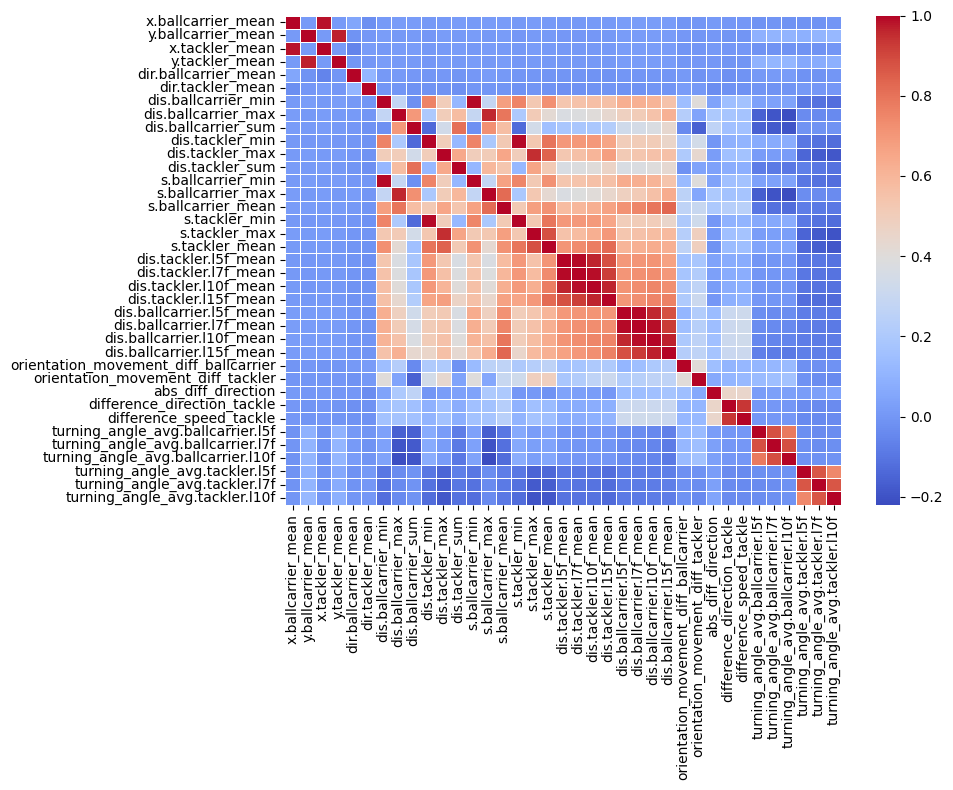

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.tight_layout()
plt.savefig("Matrix1.png", bbox_inches='tight', dpi=300)
plt.show()

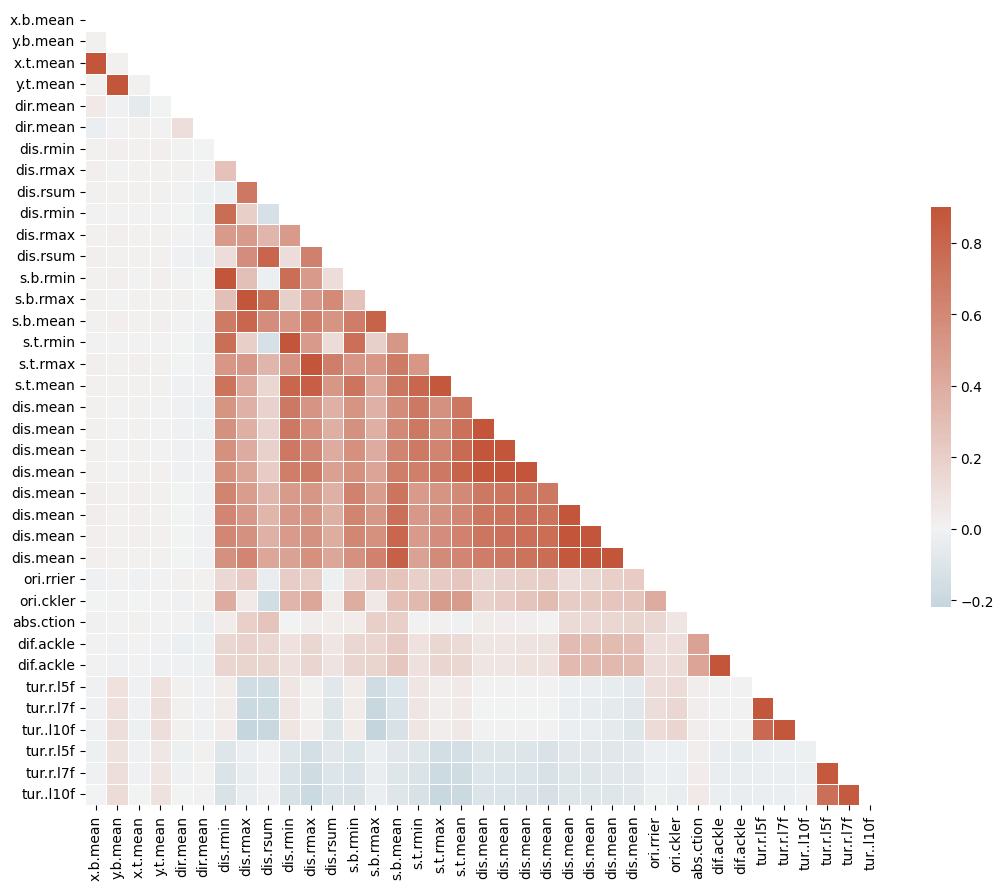

In [56]:
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

feature_names = corr.columns

shortened_feature_names = [name[:3] + "." + name[-5:].replace("_", "") for name in feature_names]

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           xticklabels= shortened_feature_names, yticklabels=shortened_feature_names)

plt.tight_layout()
plt.savefig("Matrix1.png", bbox_inches='tight', dpi=300)

plt.show()

In [57]:
# remove the corrolated features
def remove_collinear_features(x, threshold):
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            if val >= threshold:
                drop_cols.append(col.values[0])

    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

In [58]:
threshold = 0.95

X_un_Corr = remove_collinear_features(X, threshold)

Removed Columns {'x.tackler_mean', 's.tackler_max', 'y.tackler_mean', 'dis.tackler.l10f_mean', 'dis.tackler.l15f_mean', 'dis.ballcarrier.l10f_mean', 's.ballcarrier_max', 's.ballcarrier_min', 'dis.tackler.l7f_mean', 'dis.ballcarrier.l7f_mean', 'dis.ballcarrier.l15f_mean', 's.tackler_min'}


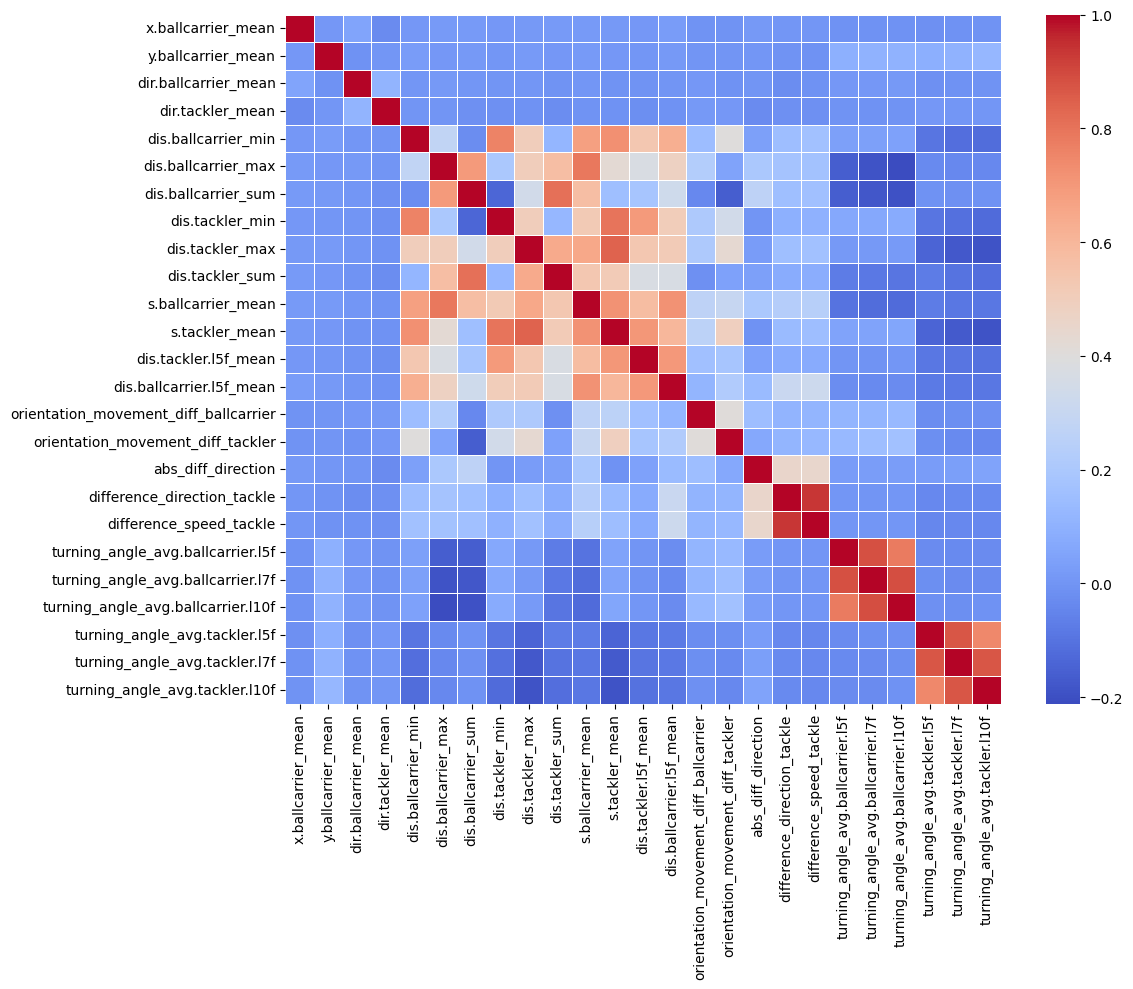

In [59]:
correlation_matrix = X_un_Corr.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.tight_layout()
plt.savefig("Matrix2.png", bbox_inches='tight', dpi=300)

plt.show()

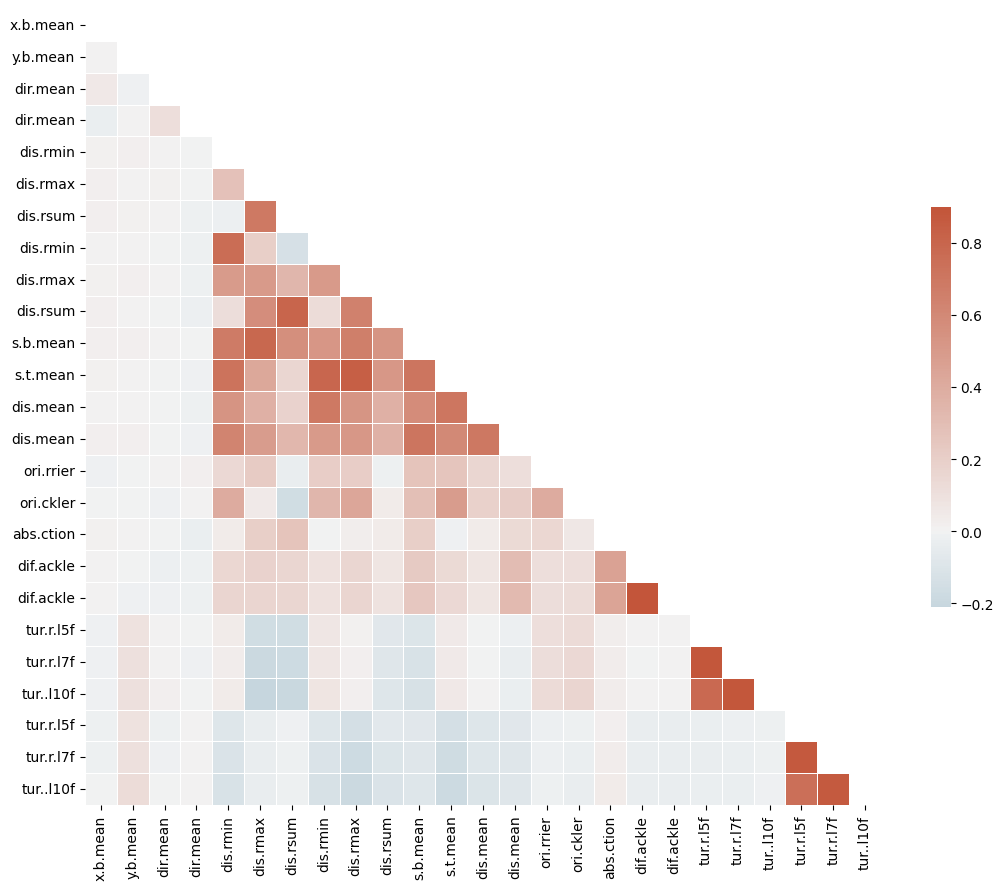

In [60]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

feature_names = correlation_matrix.columns

shortened_feature_names = [name[:3] + "." + name[-5:].replace("_", "") for name in feature_names]

ax = sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
           xticklabels= shortened_feature_names, yticklabels=shortened_feature_names)

plt.tight_layout()
plt.savefig("Matrix2.png", bbox_inches='tight', dpi=300)

plt.show()

## Use RFE

In [61]:
import sklearn
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt

In [62]:
# Make model List
def get_models():
    
    features = [5, 10, 15, 20]
    models = dict()
    
    for i in range(len(features)):
        rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select = features[i])
        model = RandomForestRegressor()
        pipeline = Pipeline(steps=[('s', rfe), ('m', model)])
        models[str(features[i])] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

In [63]:
# Evalute the model using KFold
def evaluate_model_cv(model, X, y):    
    
    cv = KFold(n_splits=10, random_state=None, shuffle=False)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [64]:
models = get_models()
results, names = list(), list()

In [65]:
for name, model in models.items():
	scores = evaluate_model_cv(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>5 -40.816 (3.943)
>10 -35.909 (3.414)
>15 -35.239 (2.857)
>20 -35.102 (3.081)


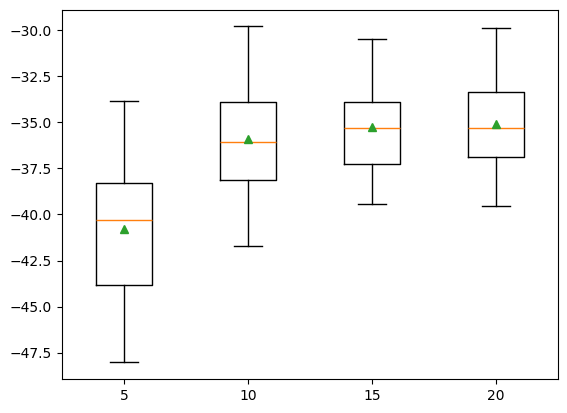

In [66]:
plt.boxplot(results, labels=[5,10,15,20], showmeans=True)
#plt.boxplot(results, labels= [5,10], showmeans=True)

plt.savefig("boxplot1.png", bbox_inches='tight', dpi=300)

plt.show()

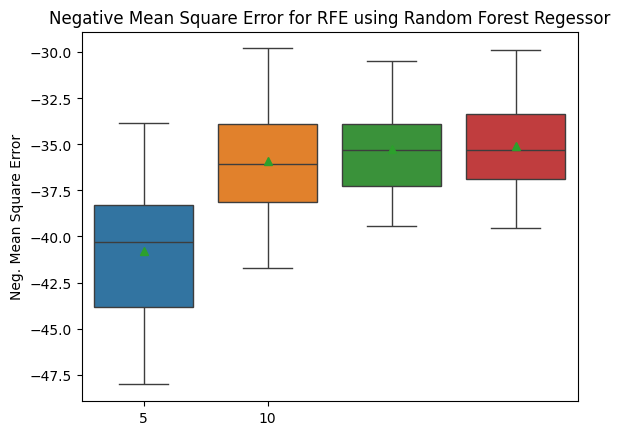

In [67]:
sns.boxplot(data=results, showmeans=True)


plt.xticks(ticks=[0, 1], labels= [5 ,10])


plt.ylabel('Neg. Mean Square Error')

plt.title('Negative Mean Square Error for RFE using Random Forest Regessor')

plt.savefig("boxplot2.png", bbox_inches='tight', dpi=300)


plt.show()

<Axes: >

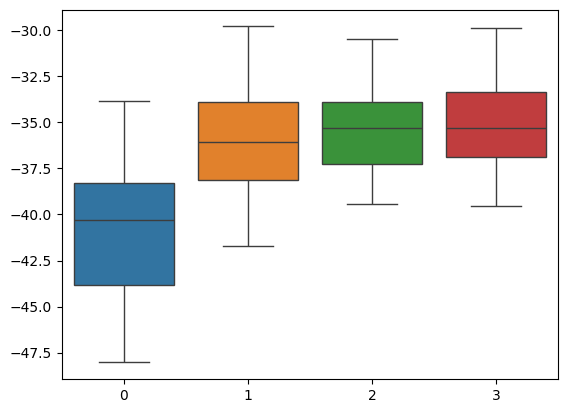

In [68]:
# Make to good looking

sns.boxplot(data=results, )

In [69]:
rfe_info = RFE(estimator=RandomForestRegressor(), n_features_to_select=20)

rfe_info.fit(X, y)

C:\Users\tobia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\tobia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\tobia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


RFE(estimator=RandomForestRegressor(), n_features_to_select=20)

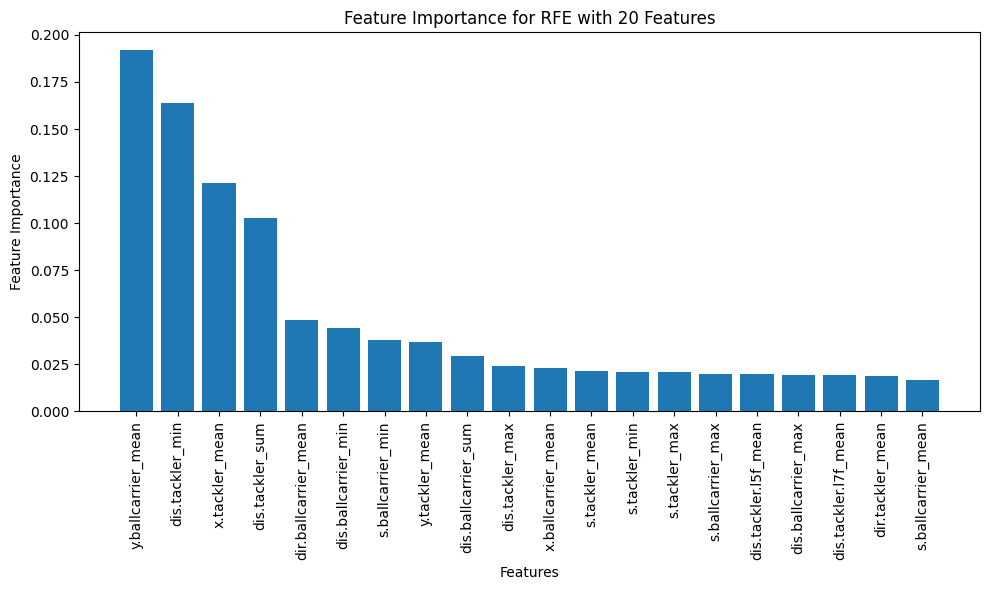

In [70]:
feature_importances = rfe_info.estimator_.feature_importances_
feature_indices = np.argsort(feature_importances)[::-1]  

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[feature_indices])
plt.xticks(range(len(feature_importances)), X.columns[feature_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for RFE with 20 Features')
plt.tight_layout()
plt.savefig("FeatureImportance")
plt.show()

C:\Users\tobia\AppData\Local\Temp\ipykernel_15504\593273851.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='Feature', y='Importance', palette=color_palette)


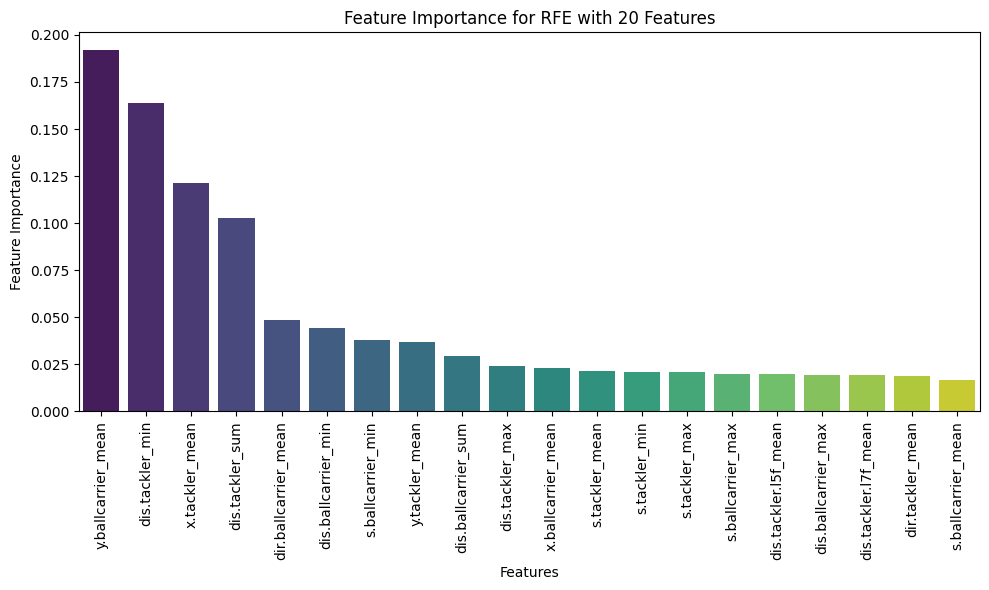

In [71]:
feature_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[feature_indices]
sorted_feature_names = X.columns[feature_indices]

# Create a DataFrame to pass to Seaborn
data = pd.DataFrame({'Feature': sorted_feature_names, 'Importance': sorted_feature_importances})

# Define color palette based on importance values
color_palette = sns.color_palette("viridis", len(sorted_feature_importances))

# Create bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Feature', y='Importance', palette=color_palette)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for RFE with 20 Features')
plt.tight_layout()
plt.savefig("FeatureImportance.png")  # Save the plot as an image
plt.show()

In [72]:
rfe_info = RFE(estimator=RandomForestRegressor(), n_features_to_select=20)

rfe_info.fit(X, y)


C:\Users\tobia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\tobia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\tobia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


RFE(estimator=RandomForestRegressor(), n_features_to_select=20)

In [73]:
for i in range(X.shape[1]):
    	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe_info.support_[i], rfe_info.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 8.000
Column: 2, Selected False, Rank: 13.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected False, Rank: 7.000
Column: 5, Selected False, Rank: 3.000
Column: 6, Selected False, Rank: 18.000
Column: 7, Selected False, Rank: 9.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected False, Rank: 17.000
Column: 10, Selected False, Rank: 16.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected False, Rank: 6.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected False, Rank: 11.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected False, Rank: 14.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected True, Rank: 1.000
Column: 23, Selected False, Rank: 12.000
Column: 24, Selected False, Rank: 4.000
Column: 25, Sel

### Test Train Split (a bit worst than CV)

In [74]:
def evaluate_model_tt(model, X, y, test_size=0.2, random_state=42):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return score

In [75]:
models = get_models()
results, names = list(), list()

In [76]:
for name, model in models.items():
	scores = evaluate_model_tt(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))


NameError: name 'train_test_split' is not defined

### Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn import svm

def train_regressor(mod, X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [ ]:
rf = RandomForestRegressor()
lin_reg = LinearRegression()
knn = KNeighborsRegressor()
ridge = Ridge()
bay_ridge = BayesianRidge()

print(train_regressor(rf, X, y))
print(train_regressor(lin_reg, X, y))
print(train_regressor(knn, X, y))
print(train_regressor(ridge, X, y))
print(train_regressor(bay_ridge, X, y))

rf.feature_importances_

In [ ]:
plt.barh(covariates, rf.feature_importances_)

In [ ]:
from pygam import LinearGAM, s
from sklearn.model_selection import train_test_split
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the GAM model with spline terms for each feature
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) +
                s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16))

# Fitting the model to the training data
gam.fit(X_train, y_train)

# Evaluating the model on the test set
from sklearn.metrics import mean_squared_error, r2_score

y_pred = gam.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

(mse, r2)


In [ ]:
import matplotlib.pyplot as plt

nrows, ncols = 4, 4

figsize_width = 15  
figsize_height_per_row = 3  
fig, axs = plt.subplots(nrows, ncols, figsize=(figsize_width, nrows * figsize_height_per_row))

# Plot the data in each subplot
for i, ax in enumerate(axs.flatten()):  # axs.flatten() creates a 1-D array of axes
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    ax.set_title(X.columns[i])
    # ax.set_xlabel('X Label')
    # ax.set_ylabel('Y Label')

plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.tight_layout()

plt.show()

# Visualization 

## 1. Plot Football Field

In [ ]:
# https://deepnote.com/@yogesh_kumar/NFL-4a717900-6a1e-4390-8671-f8604e7aa041
def create_football_field():
    
    # Create a rectangle defined via an anchor point *xy* and its *width* and *height*
    rect = patches.Rectangle((0, 0), 120, 53.3, facecolor='darkgreen', zorder=0)

    # Creating a subplot to plot our field on
    fig, ax = plt.subplots(1, figsize=(12, 6.33))

    # Adding the rectangle to the plot
    ax.add_patch(rect)

    # Plotting a line plot for marking the field lines
    plt.plot([10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 
              0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white', zorder = 0)

    # Creating the left end-zone
    left_end_zone = patches.Rectangle((0, 0), 10, 53.3, facecolor='blue', alpha=0.2, zorder=0)

    # Creating the right end-zone
    right_end_zone = patches.Rectangle((110, 0), 120, 53.3, facecolor='blue', alpha=0.2, zorder=0)

    # Adding the patches to the subplot
    ax.add_patch(left_end_zone)
    ax.add_patch(right_end_zone)

    # Setting the limits of x-axis from 0 to 120
    plt.xlim(0, 120)

    # Setting the limits of y-axis from -5 to 58.3
    plt.ylim(-5, 58.3)

    # Removing the axis values from the plot
    plt.axis('off')

    # Plotting the numbers starting from x = 20 and ending at x = 110
    # with a step of 10
    for x in range(20, 110, 10):

        # Intializing another variable named 'number'
        number = x

        # If x exceeds 50, subtract it from 120
        if x > 50:
            number = 120 - x

        # Plotting the text at the bottom
        plt.text(x, 5, str(number - 10),
                 horizontalalignment='center',
                 fontsize=20,
                 color='white')

        # Plotting the text at the top
        plt.text(x - 0.95, 53.3 - 5, str(number - 10),
                 horizontalalignment='center',
                 fontsize=20,
                 color='white',
                 rotation=180)

    # Making ground markings
    for x in range(11, 110):
            ax.plot([x, x], [0.4, 0.7], color='white', zorder = 0)
            ax.plot([x, x], [53.0, 52.5], color='white', zorder = 0)
            ax.plot([x, x], [22.91, 23.57], color='white', zorder = 0)
            ax.plot([x, x], [29.73, 30.39], color='white', zorder = 0)
    
    # Returning the figure and axis
    return fig, ax

In [ ]:
# Calling the plotting function
fig, ax = create_football_field()

# Plotting the figure
plt.show()

In [ ]:
tracking.head()

In [ ]:
tracking.shape

In [ ]:
# Convert into pands Time
tracking["time"] = pd.to_datetime(tracking["time"]).dt.time

tracking.head()

In [ ]:
# Sort df by time 

tracking = tracking.sort_values(by = "time", ascending= True).reset_index(drop= True)

tracking.head()

In [ ]:
# Pick a game and play 

gamePlayId = "202209080080"

tracking_vis = tracking.query("gamePlayId == @gamePlayId")

clubs = tracking_vis['club'].unique()

print("We look at the Game:", clubs[0] ,"vs", clubs[1])

In [ ]:
# Create table with colors
data = {
    "teamName": [
        "Buffalo Bills", "Miami Dolphins", "New England Patriots", "New York Jets",
        "Baltimore Ravens", "Cincinnati Bengals", "Cleveland Browns", "Pittsburgh Steelers",
        "Houston Texans", "Indianapolis Colts", "Jacksonville Jaguars", "Tennessee Titans",
        "Denver Broncos", "Kansas City Chiefs", "Las Vegas Raiders", "Los Angeles Chargers",
        "Dallas Cowboys", "New York Giants", "Philadelphia Eagles", "Washington Commanders",
        "Chicago Bears", "Detroit Lions", "Green Bay Packers", "Minnesota Vikings",
        "Atlanta Falcons", "Carolina Panthers", "New Orleans Saints", "Tampa Bay Buccaneers",
        "Arizona Cardinals", "Los Angeles Rams", "San Francisco 49ers", "Seattle Seahawks"
    ],
    "club": [
        "BUF", "MIA", "NE", "NYJ",
        "BAL", "CIN", "CLE", "PIT",
        "HOU", "IND", "JAX", "TEN",
        "DEN", "KC", "LV", "LAC",
        "DAL", "NYG", "PHI", "WAS",
        "CHI", "DET", "GB", "MIN",
        "ATL", "CAR", "NO", "TB",
        "ARI", "LAR", "SF", "SEA"
    ],
    "color": [
        "#00338D", "#008E97", "#002244", "#125740",
        "#241773", "#FB4F14", "#311D00", "#000000",
        "#03202F", "#002C5F", "#000000", "#002A5C",
        "#FB4F14", "#E31837", "#000000", "#0080C6",
        "#041E42", "#0B2265", "#004953", "#773141",
        "#0B162A", "#0076B6", "#203731", "#4F2683",
        "#000000", "#000000", "#000000", "#D50A0A",
        "#97233F", "#003594", "#AA0000", "#002244"
    ],
    "secondaryColor": [
        "#C60C30", "#FC4C02", "#C8102E", "#FFFFFF",
        "#000000", "#000000", "#FF3C00", "#FFB612",
        "#A71930", "#FFFFFF", "#006778", "#4B92DB",
        "#002244", "#FFB81C", "#A5ACAF", "#FFC20E",
        "#869397", "#A71930", "#A5ACAF", "#FFB612",
        "#C83803", "#B0B7BC", "#FFB612", "#FFC62F",
        "#A71930", "#0085CA", "#D3BC8D", "#34302B",
        "#000000", "#FFA300", "#B3995D", "#69BE28"
    ]
}

# Creating DataFrame
teamColor = pd.DataFrame(data)

# Displaying the DataFrame
teamColor
type(tracking_vis)

tracking_vis = pd.merge(tracking_vis, teamColor, on="club", how="left")

#add football color
tracking_vis["color"] = tracking_vis['color'].fillna('#A52A2A')
tracking_vis["secondaryColor"] = tracking_vis['secondaryColor'].fillna('#FFFFFF')

tracking_vis

In [ ]:
#join some info to tracking_vis 

tracking_vis = pd.merge(tracking_vis, plays, on = "gamePlayId", how= "left", suffixes=("","_drop"))

tracking_vis = tracking_vis.loc[:, ~tracking_vis.columns.str.endswith('_drop')]

tracking_vis["color"]

In [ ]:
# Selecting the home and away team

#need to find home team
home_team = tracking_vis.query('club == @clubs[0]')
away_team = tracking_vis.query('club == @clubs[1]')

# Selecting the football
football = tracking_vis.query('club == "football"')

In [ ]:
fig, ax = create_football_field()

s1 = 40
s2 = 10

#plot teams
home_team.plot(x='x', y='y', kind='scatter', ax=ax, color=home_team['secondaryColor'], marker = "o", s=s1) 
home_team.plot(x='x', y='y', kind='scatter', ax=ax, color=home_team['color'], marker = "o", s=s2)

away_team.plot(x='x', y='y', kind='scatter', ax=ax, color=away_team['secondaryColor'], marker = "o", s=s1)
away_team.plot(x='x', y='y', kind='scatter', ax=ax, color=away_team['color'], marker = "o", s=s2)

# plot football
football.plot(x='x', y='y', kind='scatter', ax=ax, color=football['secondaryColor'], s=s1)
football.plot(x='x', y='y', kind='scatter', ax=ax, color=football['color'], s=s2)


# Displaying the plot
plt.show()

## 2. Animate Football Field

In [ ]:
#set frameId as index
home_team.set_index('frameId', inplace=True)
away_team.set_index('frameId', inplace=True)
football.set_index('frameId', inplace=True)

# Initialize figure
fig, ax = create_football_field()

# Function to update the positions for each frame
def update(frameId):
    ax.clear()
    create_football_field(ax)  # Redraw the field

    # Update positions for the current frame
    home_team_frame = home_team.iloc[frameId]
    away_team_frame = away_team.iloc[frameId]
    football_frame = football.iloc[frameId]

    # Plotting teams and football
    ax.scatter(home_team_frame['x'], home_team_frame['y'], color=home_team_frame['color'], marker="o", s=s1)
    ax.scatter(away_team_frame['x'], away_team_frame['y'], color=away_team_frame['color'], marker="o", s=s1)
    ax.scatter(football_frame['x'], football_frame['y'], color=football_frame['color'], s=s1)

# Total number of frames (should be equal to the length of your data)
frameIds = home_team.index.unique()

# Creating the animation
ani = FuncAnimation(fig, update, frames=frameIds, interval=100)

# To display in a Jupyter notebook, use the following:
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# Or to save as a video file:
ani.save('football_animation.mp4')

plt.show()

## 3. Add the Predictions

In [ ]:
#add current time 
#add pred time 
#add actual time 

